> **University of Pisa** \
> **M.Sc Computer Science, Artificial Intelligence** \
> **Data Mining 2022/23** \
> **Authors** \
* Irene Pisani - i.pisani1@studenti.unipi.it - 560104 
* Andrea Iommi - a.iommi2@studenti.unipi.it  - 578212

---
This notebook presents an explorative analysis of the ***users.csv*** and ***tweets.csv*** datasets. In order to know more details about what we have done, we suggest to read te report.

#### Dataset used
1. *users.csv* dataset describes users **general information**.

2. *tweets.csv* reports information about the **single tweet**.

#### Tasks

1. **Data Understanding and Preparation**
2. Clustering Analysis
3. Predictive Analysis (Classification Genuine/Bot)
4. Time series Analysis

In [ ]:
%%capture
!pip install emoji

In [ ]:
#@title  Libraries

import math
import random
import time
import emoji
import collections
import seaborn as sn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
from datetime import datetime

drive.mount('/content/drive')

Mounted at /content/drive


# Task1: Data understanding & Data preparation

## Description of the "users"

***users.csv***

The data is organised in a form of an array, where the dataset attributes (aka features) are organised in columns and the users (aka instances) in rows. The dataset consists of information that describes the users subscribed one the platform (i.e. the id of the user, language, data account creation, number of total tweets published). Some users are created by the algorithm, in order to identify them there is a feature that describes the origin (bot or genuine), this attribute is defined as a symmetric binary attribute. The "users" dataset includes **11508  data observations.**

users:

* **user_id** - *Unique user id* 
* **name** - *Name of user* (object - wrong type)
* **lang** - *Language of the user* (object - wrong type)
* **bot** - *Flag that define if the user is a bot or not* (int64 - wrong type)
* **created_at** - *Timestamp of user creation* (object - wrong type)
* **statuses_count** - *Number of tweets published by the user since his registration*  (float64 - wrong type)

As we can see, by info we can observe two things:
1. There are some missing values specially in statuses_count. (399 values)
2. The type of columns are not well parsed.

### Loading the dataset

In [ ]:
# reading option: per Andrea 
users = pd.read_csv("/content/drive/MyDrive/DataMining/Sources/users.csv")

# reading option: per Irene 
# !unzip "/content/drive/MyDrive/DataMining/dataset.zip"
# users = pd.read_csv("/content/dataset/users.csv")

In order to manipulate better the attributes we rename the columns and cast them with the right type.

In [ ]:
users = users.rename(columns={'id': 'user_id', 'bot': 'real'})
users = users.astype({'name': 'string', 'lang': 'string', 'real': 'bool'})
users['created_at'] = pd.to_datetime(users['created_at']) 

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11508 non-null  int64         
 1   name            11507 non-null  string        
 2   lang            11508 non-null  string        
 3   real            11508 non-null  bool          
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), string(2)
memory usage: 460.9 KB


There are not duplicated in user_id, so we can use it as key

In [ ]:
users.user_id.duplicated().any()

False

In [ ]:
# example
users.head(3)

,user_id,name,lang,real,created_at,statuses_count
0,2353593986,Lamonica Raborn,en,True,2019-02-22 18:00:42,76.0
1,2358850842,Lourie Botton,en,False,2019-02-26 03:02:32,54.0
2,137959629,Dadan Syarifudin,en,True,2015-04-30 07:09:56,3.0


In [ ]:
print("There is row duplicate?",users[["name", "lang", "real", "created_at", "statuses_count"]].duplicated().any())

There is row duplicate? False


### General information about the attributes of "users"

#### **Name and bot**

It's worth to point out these aspects:

1. There is only a instance without name, we solve this assigning a name.
2. The number of genuine and bot users are roughly the same.

In [ ]:
print(users.isnull().any())
users[users.name.isnull()]

user_id           False
name               True
lang              False
real              False
created_at        False
statuses_count     True
dtype: bool


,user_id,name,lang,real,created_at,statuses_count
1535,2166124159,<NA>,en,False,2018-11-02 06:39:14,6566.0


In [ ]:
users.loc[users.user_id == 2166124159, "name"] = "John Smith"

In [ ]:
print(users.real.value_counts(normalize=True))

True     0.531456
False    0.468544
Name: real, dtype: float64


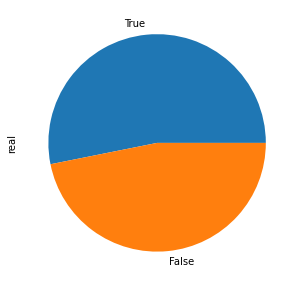

In [ ]:
users.real.value_counts().plot(kind="pie", figsize=(5,5))
plt.show()

#### **Language**

* The most frequent language is "English".

* Some languages are redundant (because pandas is case sensitive es: en-GB & en-gb) so we going to apply a straightforward lower-case function.

* There are a strange code:
 1. "Select Language..."
 2. "xx-lc"
 3. "fil"

  Talking about "Select Language..." code, in our opinion is a error caused by HTML input tag. The situation is different for "xx-lc" because, based on an [online dataset](https://www.science.co.il/language/Codes.php), there was no match with this code. We think the best thing to do is to replace these last values with mode. Finally "fil", most likely is bad-written version of "fi" (Finnish).

* There are two variant of the chinese, zh-tw and zh-cn the latter with only one user, to improve the analysis we take only a general form: zh, the same thing append to "en".

* To reduce the number of different languages, we assign the label "other" on the language that are less than 10 users.



In [ ]:
pd.DataFrame(users.lang.value_counts())

,lang
en,9970
it,906
es,319
pt,65
en-gb,50
ru,42
fr,36
ja,33
zh-tw,17
tr,14


In [ ]:
users.lang = users.lang.str.lower()
users.loc[users.lang == "select language...", "lang"] = "en"
users.loc[users.lang == "xx-lc", "lang"] = "en"
users.loc[users.lang == "fil"  , "lang"] = "fi"
users.loc[users.lang == "zh-cn", "lang"] = "zh"
users.loc[users.lang == "zh-tw", "lang"] = "zh"
users.loc[users.lang == "en-gb", "lang"] = "en"
users.loc[users.lang == "en-au", "lang"] = "en"

t = users.lang.value_counts()
users.lang = users.lang.apply(lambda row: 'oth' if (t < 10)[row] else row)

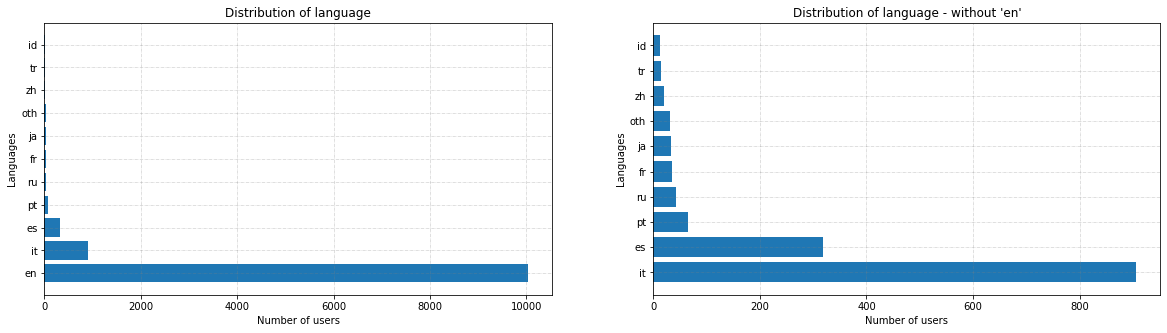

In [ ]:
f, axs = plt.subplots(ncols=2, figsize=(20,5))

axs[0].barh(users.lang.value_counts().index,users.lang.value_counts())
axs[0].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)   
axs[0].set_title("Distribution of language")
axs[0].set_xlabel("Number of users")
axs[0].set_ylabel("Languages")

axs[1].barh(users[(users.lang != 'en')].lang.value_counts().index, users[(users.lang != 'en')].lang.value_counts())
axs[1].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
axs[1].set_title("Distribution of language - without 'en'")
axs[1].set_xlabel("Number of users")
axs[1].set_ylabel("Languages")

plt.show()

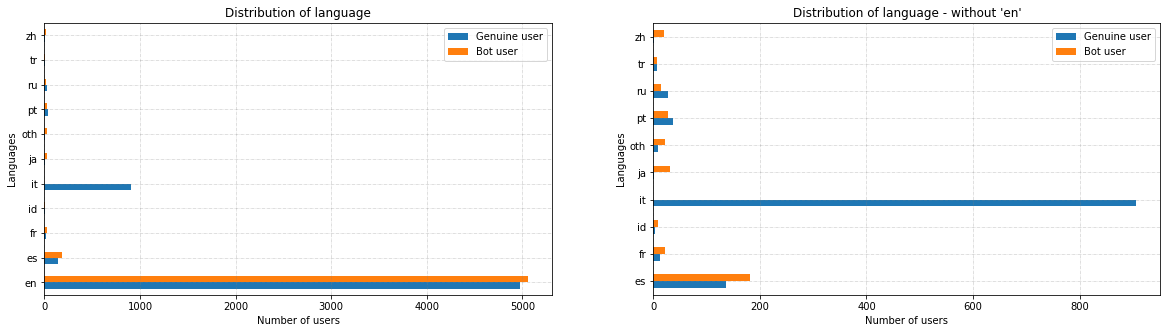

In [ ]:
_, axs = plt.subplots(ncols=2, figsize=(20,5))

values_real = users.groupby(users[(users.real == True)].lang).lang.count().sort_values()
values_bot = users.groupby(users[(users.real == False)].lang).lang.count().sort_values()

pd.DataFrame({'Genuine user': values_real, 'Bot user' : values_bot}).plot(kind="barh", ax=axs[0])
axs[0].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)   
axs[0].set_title("Distribution of language")
axs[0].set_xlabel("Number of users")
axs[0].set_ylabel("Languages")

values_real = users[(users.lang != 'en')].groupby(users[(users.real == True)].lang).lang.count()
values_bot = users[(users.lang != 'en')].groupby(users[(users.real == False)].lang).lang.count()

pd.DataFrame({'Genuine user': values_real, 'Bot user' : values_bot}).plot(kind="barh", ax=axs[1])
axs[1].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
axs[1].set_title("Distribution of language - without 'en'")
axs[1].set_xlabel("Number of users")
axs[1].set_ylabel("Languages")

plt.show()


#### **Created_at**
We can observe that except for the last year (2020) there is a incremental tendency to subscribe to the platform.

min   2012-01-24 01:57:38
max   2020-04-21 07:28:31
Name: created_at, dtype: datetime64[ns]


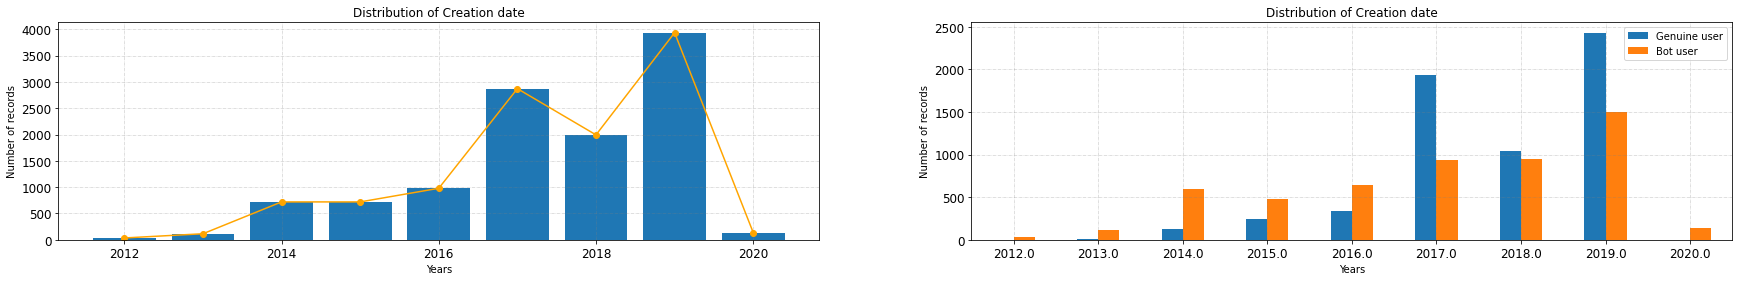

In [ ]:
print(users['created_at'].agg(['min', 'max']))

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(28, 4))

values = users.groupby(users.created_at.dt.year).created_at.count()
years = np.sort(users.created_at.dt.year.unique())

ax[0].bar(years,values)
ax[0].plot(years,values, '-o', color='orange')
ax[0].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
ax[0].set_title("Distribution of Creation date")
ax[0].set_xlabel("Years")
ax[0].set_ylabel("Number of records")
ax[0].tick_params(labelrotation=0, labelsize='large')

values_real = users.groupby(users[(users.real == True)].created_at.dt.year).created_at.count()
values_bot = users.groupby(users[(users.real == False)].created_at.dt.year).created_at.count()

pd.DataFrame({'Genuine user': values_real, 'Bot user' : values_bot}).plot(kind="bar", ax=ax[1])
ax[1].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
ax[1].set_title("Distribution of Creation date")
ax[1].set_xlabel("Years")
ax[1].set_ylabel("Number of records")
ax[1].tick_params(labelrotation=0, labelsize='large')

plt.show()

We have the spike on February and March 2019

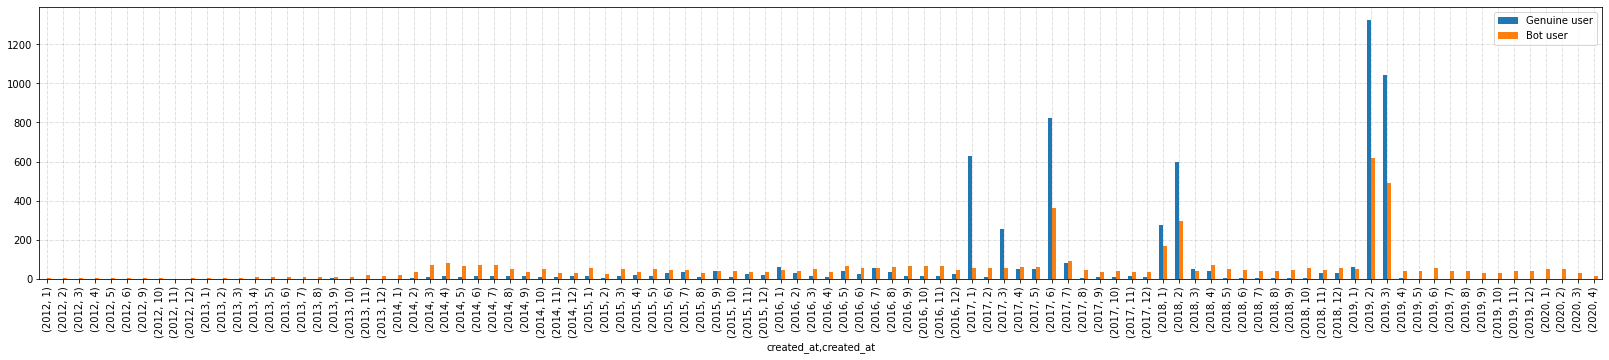

In [ ]:
real = users[(users.real==True)].created_at
bot = users[(users.real==False)].created_at

pd.DataFrame({'Genuine user': real.groupby([real.dt.year,real.dt.month]).count(), 'Bot user' : bot.groupby([bot.dt.year,bot.dt.month]).count()}).plot(kind="bar",figsize=(28, 5))
plt.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
plt.show()

We show the number of registration per year 2019

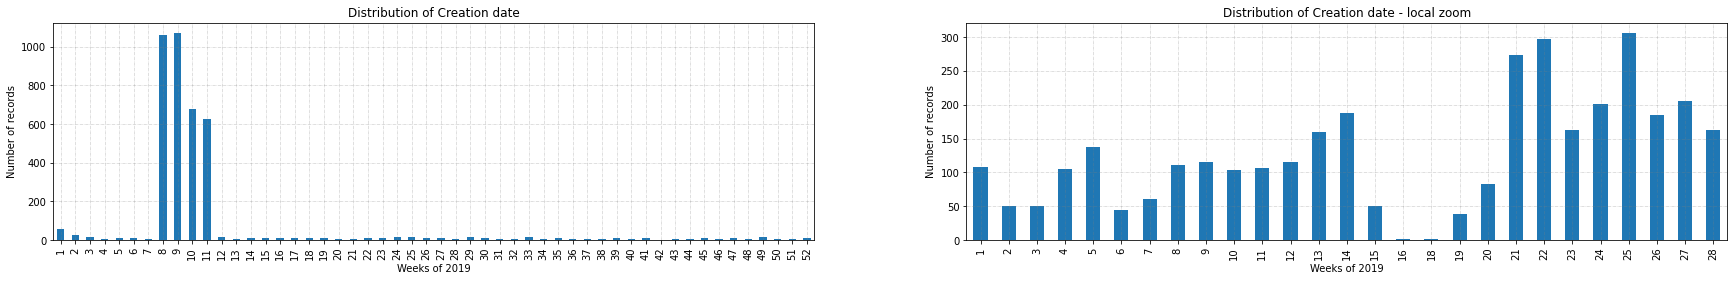

In [ ]:
_, ax = plt.subplots(nrows=1, ncols=2,figsize=(28, 4))

t = users.created_at.dt
t2 = t.isocalendar().week

users[t.year == 2019].created_at.groupby([t.isocalendar().week]).agg('count').plot(kind="bar",ax=ax[0])
ax[0].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
ax[0].set_title("Distribution of Creation date")
ax[0].set_xlabel("Weeks of 2019")
ax[0].set_ylabel("Number of records")

users[(t.year == 2019)&((t2==8)|(t2==9)|(t2==10)|(t2==11))].created_at.groupby([t.day]).agg('count').plot(kind="bar",ax=ax[1])
ax[1].grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.5) 
ax[1].set_title("Distribution of Creation date - local zoom")
ax[1].set_xlabel("Weeks of 2019")
ax[1].set_ylabel("Number of records")
plt.show()

#### **statuses_count**

We can observe that the behavior between real users and bot about the numer of tweets published is quite different.

In [ ]:
a = users.statuses_count[users.real == True].describe()
b = users.statuses_count[users.real == False].describe()
pd.DataFrame([a,b],index=["Real user","Bot user"])

,count,mean,std,min,25%,50%,75%,max
Real user,6116.0,1185.102845,5373.550630,0.0,32.0,53.0,78.0,214410.0
Bot user,4993.0,11638.219107,26719.438432,0.0,61.0,2041.0,11585.0,399555.0


We are going to replace the missing values using *Tweets* dataset

In [ ]:
print("How much missing values?",len(users[users.statuses_count.isnull()]))

How much missing values? 399


Only the bot have a missing values in statuses_count

In [ ]:
len(users[(users.real == True) & (users.statuses_count.isnull())])

0

In [ ]:
tot = users.statuses_count.sum()
real = users[users.real == True].statuses_count.sum()
bot = users[users.real == False].statuses_count.sum()

print("The number of tweets published by bot user are roughly",round((bot/real - 1)*100,3),"% respect to real user\n")
print("Tweets made by Genuine users", round(real/tot,3)*100, " %\n")
print("Tweets made by Bot users", round(bot/tot,3)*100, " %")

users.sort_values(by="statuses_count",ascending=False).head(10)

The number of tweets published by bot user are roughly 701.723 % respect to real user

Tweets made by Genuine users 11.1  %

Tweets made by Bot users 88.9  %


,user_id,name,lang,real,created_at,statuses_count
1391,1038481676,News This Second,en,False,2017-12-29 01:09:46,399555.0
8703,34116023,Mary,en,False,2014-04-24 00:50:09,367191.0
3552,2690589608,松戸けんま,ja,False,2019-07-31 17:14:09,334636.0
8218,15448383,Inquirer Group,en,False,2013-07-18 00:36:41,333504.0
1860,83296294,Henry Stradford,en,False,2014-10-20 04:27:38,328921.0
11054,23026561,FilaFresh,en,False,2014-03-08 03:50:18,322470.0
4177,1939977158,苺ましかく,ja,False,2018-10-08 06:08:48,313032.0
8160,37407255,অগ্নিভ নিয়োগী,en,False,2014-05-05 12:17:01,283536.0
5706,262531823,Abid,en,False,2016-03-09 06:40:22,274989.0
9303,23444554,Dame Campaigner VC,en,False,2014-03-11 15:01:07,249449.0


As we can see, the genuine users are published less post than bot users.

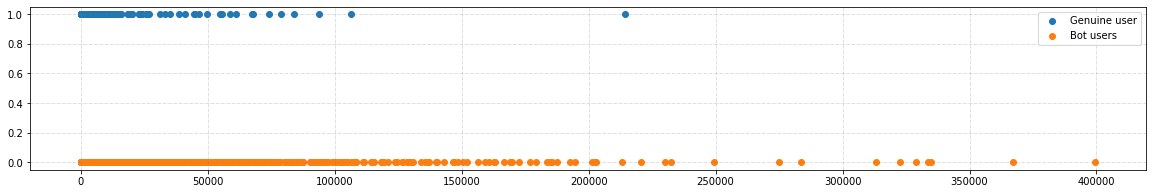

In [ ]:
plt.figure(figsize=(20,3))

y, x = users[users.real == True].real , users[users.real == True].statuses_count
plt.scatter(x,y, label="Genuine user")

y, x = users[users.real == False].real , users[users.real == False].statuses_count
plt.scatter(x,y, label="Bot users")

plt.legend()
plt.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
plt.show()

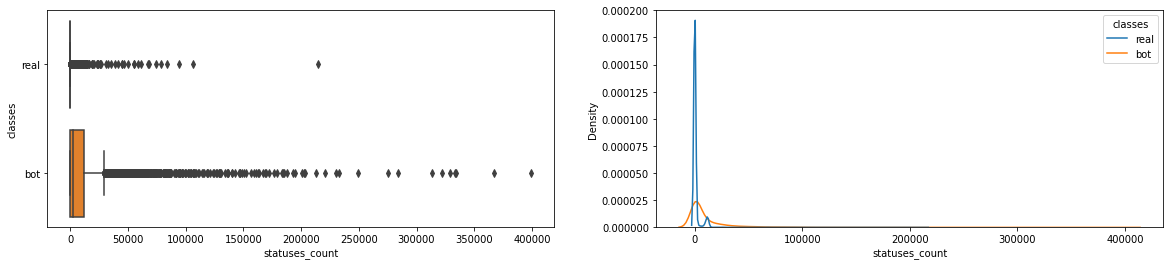

In [ ]:

temp = {True:'real', False:'bot'}
users['classes'] = users['real'].map(temp)

_, axes = plt.subplots(1, 2, figsize=(20, 4))

sn.boxplot(data=users, x="statuses_count", y="classes", ax = axes[0]) 
sn.kdeplot(data=users, x="statuses_count", hue="classes", ax = axes[1])  
plt.show()

In [ ]:
users.drop(columns = "classes", inplace = True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         11508 non-null  int64         
 1   name            11508 non-null  string        
 2   lang            11508 non-null  object        
 3   real            11508 non-null  bool          
 4   created_at      11508 non-null  datetime64[ns]
 5   statuses_count  11109 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(1), int64(1), object(1), string(1)
memory usage: 460.9+ KB


## Description of the "tweets"

***tweets.csv***

Also in this case, the data is organised in a form of an array. The dataset consists of tweets published by the user and its information. The "tweets" dataset includes **13 664 696 data observations.**

tweets:

* **id** - *Unique tweet id*
* **user_id** - *User id, who has published the tweet*
* **retweet_count** - *The number of retweet*
* **reply_count** - *The number of comments received*
* **favorite_count** - *The number of like received*
* **num_hashtags** - *The number of hashtag in the tweet text*
* **num_mentions** - *The number of mention in the tweet text*
* **created_at** - *Timestamp of tweet creation*
* **text** - *Text of the tweet*

In the preliminary analysis we have noticed that the column **id** has a lot of errors:

* Null values
* Duplicate
* Alphanumeric values 

too much errors do not give us a lot of information, so in order to ease the computation we reset it. 

In [ ]:
# reading option: per Andrea
tweets = pd.read_csv("/content/drive/MyDrive/DataMining/Sources/tweets.csv")

# reading option: per Irene
# tweets = pd.read_csv("/content/dataset/tweets.csv")

tweets.drop("id",axis=1,inplace=True)
tweets.reset_index(inplace=True)
tweets = tweets.rename(columns={'index': 'id'})

After we loaded the dataset, we observe:

*   All column are not parsed
*   There are several missing values in all columns except for **created_at**


In [ ]:
tweets.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13664696 entries, 0 to 13664695
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              13664696 non-null  int64 
 1   user_id         13447413 non-null  object
 2   retweet_count   13227562 non-null  object
 3   reply_count     13016818 non-null  object
 4   favorite_count  13017154 non-null  object
 5   num_hashtags    12607172 non-null  object
 6   num_urls        13016073 non-null  object
 7   num_mentions    12810531 non-null  object
 8   created_at      13664696 non-null  object
 9   text            13126975 non-null  object
dtypes: int64(1), object(9)
memory usage: 1.0+ GB


It is useful understand the degree of "errors" in the dataset performing the percentage. If there was a high percentage we have considered to remove some columns.

In [ ]:
def f(i:int):
  t = tweets[tweets.columns[i]]
  return len(t[(t.isnull())|(t.str.isnumeric()==False)])

columns = ["user_id","retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions","num of null texts"]
ids=[1,2,3,4,5,6,7]

tot = len(tweets)
wrong_data = [f(i) for i in ids]
wrong_data_p = [str(round(i / tot,4))+" %" for i in wrong_data]

n = len(tweets[tweets.text.isnull()]) # Number of null texts
wrong_data.append(n)
wrong_data_p.append(str(round(n/tot,4))+" %") # Percentage of null texts

pd.DataFrame([wrong_data,wrong_data_p],columns=columns,index=["Wrong values","Percentage"])

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,num of null texts
Wrong values,434013,625542,1853912,1853923,1854130,1853914,988054,537721
Percentage,0.0318 %,0.0458 %,0.1357 %,0.1357 %,0.1357 %,0.1357 %,0.0723 %,0.0394 %


## Data preparation of tweets & users

### Remove wrong values & Outlier detection

Although we are in the Data Understating analysis, we have to pre-process the data before display charts and do the statistic because in the dataset there are several inconsistent values. In fact, the next part consists in a some techniques applied to remove the error and replace the missing values. We keep track the number of rows deleted to have a clear vision of what we are doing.

In [ ]:
deletes = {}

#### 1) **Null user id** (code A)
Two situation can happen:

1. The user_id is null, and there are not other rows with the same *created_at*

2. The user_id is null, but there is another row that has the same *create_at* and *text*.

In the former case we delete it because we cannot retrieve any information for the user. In the latter, we can say the row with null user_id is a just a meaningless duplicated row and we eliminate also it.

In [ ]:
tweets[tweets.user_id.isnull()].head(3)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
42,42,NaN,1,NaN,ai6,NaN,0.0,NaN,2019-10-30 06:11:12,NaN
174,174,NaN,0,0.0,0.0,6r5ak3,0.0,0,2019-10-02 17:25:04,"I get to go to a lot of overseas places, like ..."
178,178,NaN,0,0.0,0.0,0.0,1.0,0,2019-09-25 22:43:31,Check out these spooky skull candles! http://...


In [ ]:
# example
tweets[(tweets.created_at == "2019-10-02 17:25:04")]

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
174,174,NaN,0,0.0,0.0,6r5ak3,0.0,0,2019-10-02 17:25:04,"I get to go to a lot of overseas places, like ..."
148130,148130,220116356,0,0,0,0,0,0,2019-10-02 17:25:04,"I get to go to a lot of overseas places, like ..."
3641664,3641664,220116356,0,0,0,0,0,0,2019-10-02 17:25:04,"I get to go to a lot of overseas places, like ..."


In [ ]:
first = len(tweets)
tweets.drop(tweets[tweets.user_id.isnull()].index, inplace=True)
deletes["A"] = first-len(tweets)

#### **2) Tweets with the same user_id & created_at and text** (code B)

Sometimes in the dataset there are rows that share the same user_id text and created_at, in this case it makes no sense to keep all copies.

In [ ]:
tweets[tweets[['user_id', 'text','created_at']].duplicated()].head(3)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
7530,7530,15888676,0,0,0,0,0,0,2020-03-25 00:35:19,Pero claro que se va la luz. Pinchi lluvia ogt...
9201,9201,66949187,0,0,0,2,1,0,2019-01-10 15:43:31,oh! i ❤️ *on my way home #maroon5 #tickets
15725,15725,467057265,0,0,1,0,0,0,2019-10-31 15:43:28,"Nel dubbio, tu esagera."


In [ ]:
# example
tweets[tweets.created_at == "2020-03-25 00:35:19"]

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
911,911,15888676,0,NaN,0.0,0.0,0.0,0,2020-03-25 00:35:19,Pero claro que se va la luz. Pinchi lluvia ogt...
7530,7530,15888676,0,0,0,0,0,0,2020-03-25 00:35:19,Pero claro que se va la luz. Pinchi lluvia ogt...


In [ ]:
first = len(tweets)
tweets.drop_duplicates(subset=['user_id', 'text', 'created_at'], keep="first",inplace=True)
deletes["B"] = first-len(tweets)

#### **3) Not-numeric user_id** (code C)

In the user_id column may find a non numeric user_id, since we cannot associate to real user, we delete them

In [ ]:
tweets[tweets.user_id.str.isnumeric() == False].head(3)

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text
84,84,nviem1q,0,0.0,NaN,NaN,NaN,NaN,2018-06-02 03:24:58,"@danloving It’a a rarity, for sure. But for cr..."
127,127,wdquew,NaN,NaN,NaN,NaN,0.0,1,2019-07-30 18:58:59,@PerfectDKids I'm not a bad kid
252,252,uzx,0,0.0,NaN,0.0,0.0,0,2018-07-28 16:20:17,"""Tutte le persone crudeli si definiscono campi..."


In [ ]:
first = len(tweets)
tweets.drop(tweets[tweets.user_id.str.isnumeric() == False].index, inplace=True)
deletes["C"] = first-len(tweets)

#### **Value replacement (Wrong values) & Columns casting**

In this phase we will replace all *values* that are not correct. We think that the better values we can place is the median on subset of correct values. In order to achieve realistic values, we calculate the median for tweets written by genuine and bot separately.

In [ ]:
tweets = tweets.astype({'user_id': 'int'})
tweets = pd.merge(tweets,users[["user_id","real"]])

In [ ]:
tweets_attrib = tweets.loc[:,["retweet_count","reply_count","favorite_count","num_hashtags","num_urls","num_mentions"]]  

In [ ]:
# First replace the wrong values with -1
for attrib in tweets_attrib.columns:
  att = tweets[attrib]
  tweets.loc[(att.isnull()|(att.str.isnumeric() == False)), attrib] = -1

# then we cast correctly the columns
tweets = tweets.astype({
  'retweet_count': 'float',
  'reply_count': 'float',
  'favorite_count': 'float',
  'num_hashtags': 'float',
  'num_urls': 'float',
  'num_mentions': 'float',
  'text': 'string'
})
tweets.text.fillna("",inplace=True)
tweets['created_at'] = pd.to_datetime(tweets['created_at'])
tweets["text_len"] = tweets["text"].str.len()
tweets["num_emoji"] = tweets['text'].apply(lambda x : emoji.emoji_count(str(x)))

for attrib in tweets_attrib.columns:
  att = tweets[attrib]
  real, not_real = tweets.real == True, tweets.real == False

  tweets.loc[(att == -1) & real, attrib] = tweets.loc[(att >= 0) & real, attrib].median()
  tweets.loc[(att == -1) & not_real, attrib] = tweets.loc[(att >= 0) & not_real, attrib].median()

tweets.drop(["text","real"],inplace=True,axis=1)

#### **5) Remove zero-values** (code D)




The rows that are no relevant information (all zero-values and empty text) are deleted

In [ ]:
zeros = tweets[(tweets.retweet_count == 0) & (tweets.reply_count == 0) & (tweets.favorite_count == 0) & (tweets.text_len == 0 ) & 
       (tweets.num_hashtags == 0) & (tweets.num_urls == 0) & (tweets.num_mentions == 0)]
zeros 

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at,text_len,num_emoji
34,119293,327746321,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-15 21:36:33,0,0
45,154005,327746321,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-04 04:15:53,0,0
76,308414,327746321,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-27 05:08:58,0,0
98,370486,327746321,0.0,0.0,0.0,0.0,0.0,0.0,2019-11-05 23:02:03,0,0
107,388379,327746321,0.0,0.0,0.0,0.0,0.0,0.0,2019-10-09 18:26:42,0,0
...,...,...,...,...,...,...,...,...,...,...,...
10230240,8706703,1208844938,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-11 17:34:14,0,0
10230254,8939309,168686865,0.0,0.0,0.0,0.0,0.0,0.0,2017-12-18 06:23:26,0,0
10230260,6198808,141394735,0.0,0.0,0.0,0.0,0.0,0.0,2017-11-27 02:17:24,0,0
10230273,6129076,435591257,0.0,0.0,0.0,0.0,0.0,0.0,2017-11-22 19:23:33,0,0


In [ ]:
first = len(tweets)
tweets.drop(zeros.index, inplace=True)
deletes["D"] = first-len(tweets)

#### **6) Check the real user_id (Code E)**

We check if there are tweets that is associated to not valid user (aka user that not exist), we create two arrays: the first contains the real user_id taken from user dataset, the second is an array that contains ids of users present in tweets. We save a list of user that not exist and we will go to eliminate them in tweets.

In [ ]:
myset = set()
ids_users = users.user_id.unique()
ids_tweets = tweets.user_id.unique()
for i in ids_tweets: 
  if not np.isin(i, ids_users): myset.add(i)

In [ ]:
print("Number of users that are not present in users.csv: ",len(myset))
deletes["E"] = len(myset)

Number of users that are not present in users.csv:  0


As we can see, there are not mismatch

#### **Fix statuses_count**

In this phase we are going to replace the missing values on statuses_count, base on the number of tweets crawled in tweets.csv, we use the method just for estimate a reliable number of tweets. 

In [ ]:
users = users.join(pd.DataFrame(tweets.groupby(tweets.user_id).user_id.count()).rename(columns={"user_id": "tw_crwl"}),on="user_id")
users.loc[users.statuses_count.isnull(),"statuses_count"] = -1
users["statuses_count"] = users.apply(lambda x: x["tw_crwl"] if x["statuses_count"] == -1 else x["statuses_count"],axis=1)
users.drop("tw_crwl",axis=1,inplace=True)

#### **7) Outliers** (code F)

We observe that the values are very sparse, so it would useful apply a log-scale

In [ ]:
tweets_attrib = tweets.loc[:,["retweet_count", "reply_count", "favorite_count", "num_hashtags", "num_urls", "num_mentions", "text_len", "num_emoji"]]  

In [ ]:
# we add + 1 because there are value that are zero, and this leads to -inf
for attrib in tweets_attrib.columns:  
  tweets[attrib] = np.log(tweets[attrib] + 1)

#####  Boxplot Analysis

We chose to remove some "extreme" values in order to reduce the spread of the data

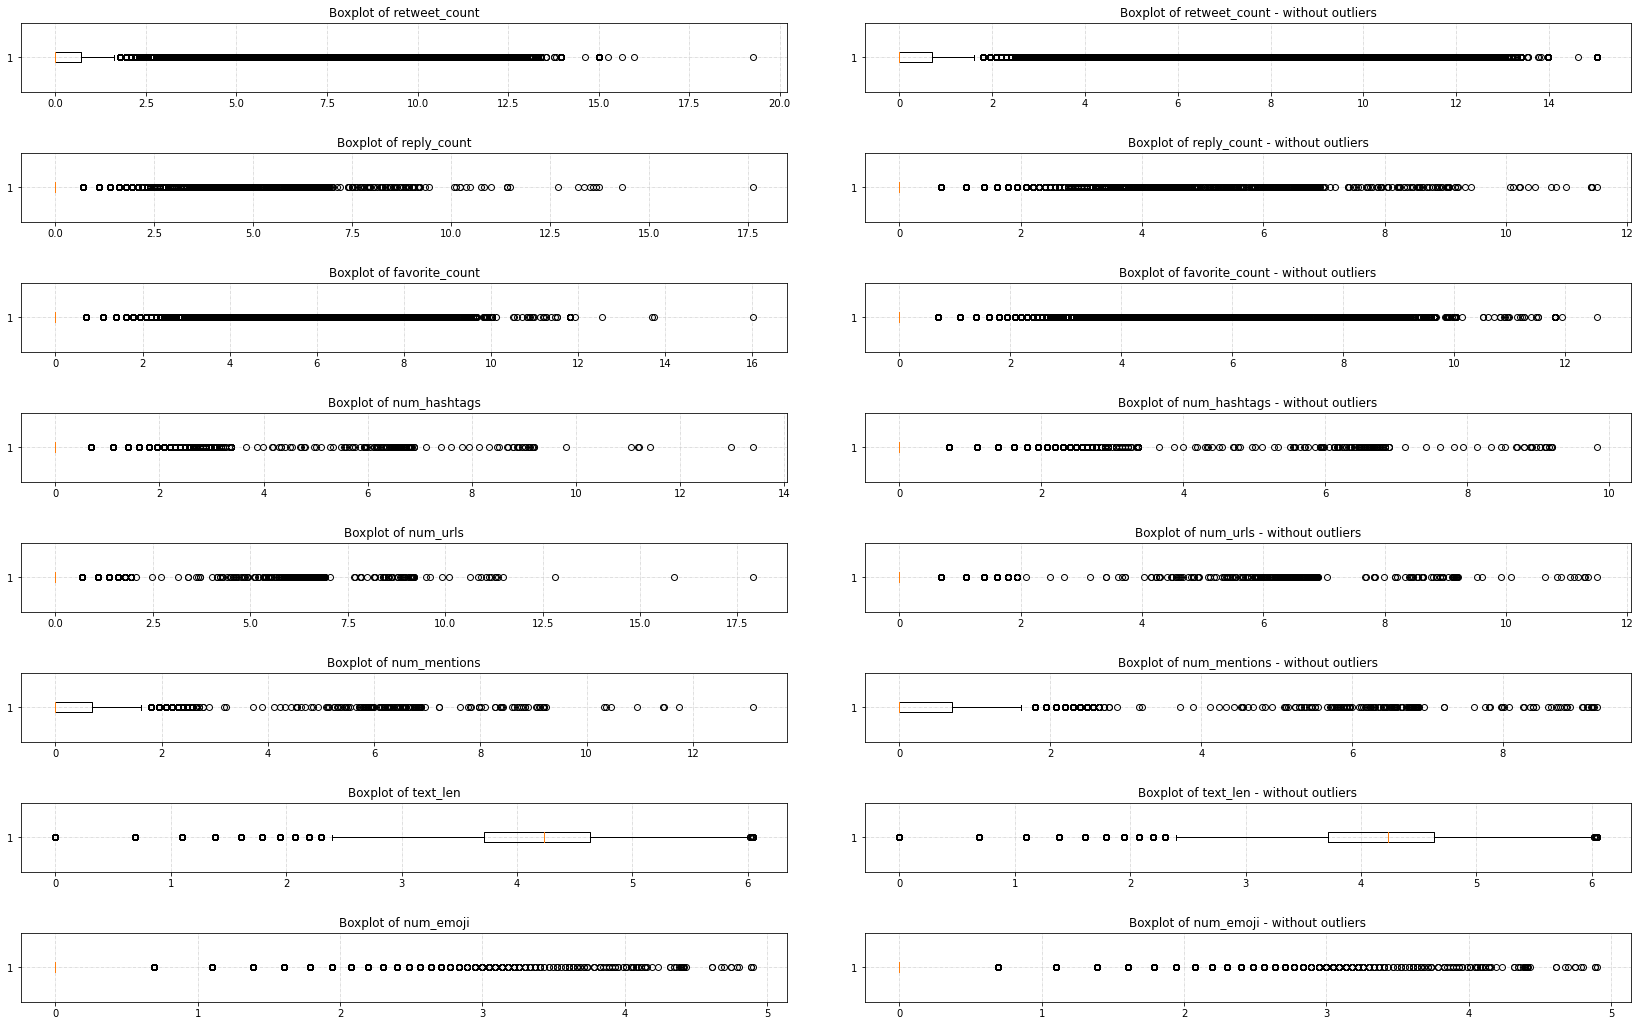

In [ ]:
f, axs = plt.subplots(ncols=2,nrows=8, figsize=(24,15))
f.tight_layout(pad=4)

thresholds =[15.1, 12, 13, 10, 12, 10, float('inf'),float('inf')]

for idx,i in enumerate(tweets_attrib.columns):
  axs[idx][0].boxplot(tweets[i],vert=False)
  axs[idx][0].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
  axs[idx][0].set_title("Boxplot of " + i)

  axs[idx][1].boxplot(tweets[i][tweets[i] < thresholds[idx]],vert=False)
  axs[idx][1].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
  axs[idx][1].set_title("Boxplot of " + i + " - without outliers")
  
plt.show()

In [ ]:
outliers = tweets[(tweets.retweet_count >= thresholds[0])|(tweets.reply_count >= thresholds[1])|(tweets.favorite_count >= thresholds[2])|
       (tweets.num_hashtags >= thresholds[3])|(tweets.num_urls >= thresholds[4])|(tweets.num_mentions > thresholds[5])]

In [ ]:
first = len(tweets)
tweets.drop(outliers.index,inplace=True)
deletes["F"] = first-len(tweets)

In [ ]:
pd.DataFrame(deletes.values(),
             index=["Null id","Duplicate tweets","Not numeric id","Zeros tweets","Users mismatch","Outliers"],
             columns=["Row eliminated"])

,Row eliminated
Null id,217283
Duplicate tweets,2999450
Not numeric id,216730
Zeros tweets,139985
Users mismatch,0
Outliers,33


In [ ]:
print("Total tweets removed: ",sum(deletes.values()))
print("Percentage of row deleted in tweets from cleaning phase: ",round((13664696/sum(deletes.values())),3),"%")

Total tweets removed:  3573481
Percentage of row deleted in tweets from cleaning phase:  3.824 %


In [ ]:
# reverse of function applied
for attrib in tweets_attrib.columns:  
  tweets[attrib] = np.exp(tweets[attrib]) - 1

In [ ]:
users.to_csv("/content/drive/MyDrive/DataMining/users2class_and_ts.csv", index=True)
tweets.to_csv("/content/drive/MyDrive/DataMining/tweets2class_and_ts.csv", index=True)

### Charts

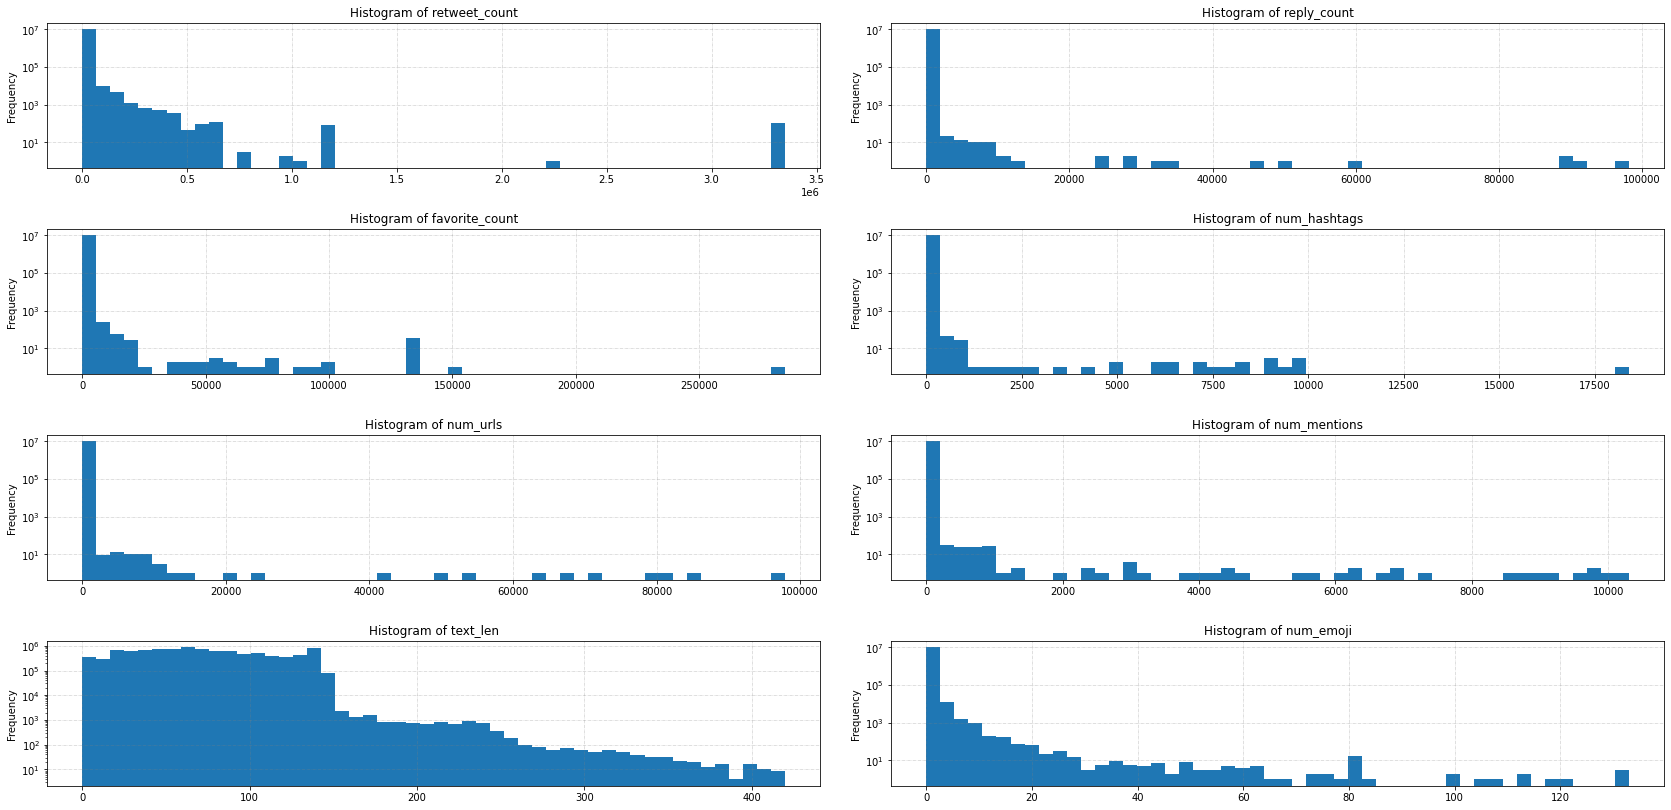

In [ ]:
f, axs = plt.subplots(ncols=2, nrows=4, figsize=(24,12))
f.tight_layout(pad=4)

for idx, attrib in enumerate(tweets_attrib.columns):  
  axs[int(idx/2)][idx%2].hist(tweets[attrib],bins=50)
  axs[int(idx/2)][idx%2].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
  axs[int(idx/2)][idx%2].set_yscale('log')
  axs[int(idx/2)][idx%2].set_title("Histogram of "+attrib)
  axs[int(idx/2)][idx%2].set_ylabel("Frequency")
plt.show()

In [ ]:
tweets.describe()

,id,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,text_len,num_emoji
count,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07,1.009039e+07
mean,6.180250e+06,8.313860e+08,5.688384e+02,1.228860e-01,1.831117e+00,1.871511e-01,2.689536e-01,5.663374e-01,7.198092e+01,2.726633e-02
std,3.898956e+06,8.543924e+08,1.412088e+04,7.004556e+01,2.934953e+02,1.264884e+01,7.341197e+01,1.179829e+01,3.966697e+01,3.338947e-01
min,0.000000e+00,6.780330e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.769679e+06,2.295795e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01,0.000000e+00
50%,5.869184e+06,4.680718e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.800000e+01,0.000000e+00
75%,9.422880e+06,1.252099e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.020000e+02,0.000000e+00
max,1.366470e+07,3.164942e+09,3.350111e+06,9.819200e+04,2.848990e+05,1.839700e+04,9.790600e+04,1.030400e+04,4.200000e+02,1.330000e+02


## Generating new attributes

In this phase we create a new dataset where we add new indicators derived by tweets' information at the end of this phase, we will join this dataset with *users.csv* to reach the final dataset to perform the clustering analysis.

In [ ]:
indicators = pd.DataFrame(tweets.user_id.unique())
indicators.set_index(0, inplace=True)
indicators.index.names = ['user_id']

#### Average, Standard deviation, Maximum

In [ ]:
# mean of characters contained in a tweet
indicators['Achars'] = tweets.groupby("user_id").text_len.mean()
indicators['Schars'] = tweets.groupby("user_id").text_len.std().fillna(0)

# mean likes received for tweets
indicators['Alike'] = tweets.groupby("user_id").favorite_count.mean()

# mean emoji contained in a tweet
indicators['Aemoji'] = tweets.groupby("user_id").num_emoji.mean()

# mean retweets received for tweets
indicators['Aretwee'] = tweets.groupby("user_id").retweet_count.mean()
indicators['Sretwee'] = tweets.groupby("user_id").retweet_count.std().fillna(0)

indicators['Areply'] = tweets.groupby("user_id").reply_count.mean()
indicators['Sreply'] = tweets.groupby("user_id").reply_count.std().fillna(0)

indicators['Ahash'] = tweets.groupby("user_id").num_hashtags.mean()
indicators['Shash'] = tweets.groupby("user_id").num_hashtags.std().fillna(0)
indicators['Thash'] = tweets.groupby("user_id").num_hashtags.sum()

indicators['Aurls'] = tweets.groupby("user_id").num_urls.mean()

indicators['Aments'] = tweets.groupby("user_id").num_mentions.mean()
indicators['Sments'] = tweets.groupby("user_id").num_mentions.std().fillna(0)

#### Average number of tweets per Years/Months/Days

In [ ]:
indicators["Ayears"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year]).size().groupby(level = 0).mean()
    
indicators["Amonths"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year,tweets.created_at.dt.month]).size().groupby(level = 0).mean()

indicators["Adays"] = tweets.groupby(
    [tweets.user_id, tweets.created_at.dt.year,tweets.created_at.dt.month,tweets.created_at.dt.day]).size().groupby(level = 0).mean()

#### Most published tweets per Year/Month/DayofWeek

In [ ]:
indicators["Fyear"] = pd.DataFrame(tweets.groupby([tweets.user_id, tweets.created_at.dt.year])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

indicators["Fmonth"] = pd.DataFrame(tweets.groupby([tweets.user_id, tweets.created_at.dt.month])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

indicators["Fday"] = pd.DataFrame(tweets.groupby([tweets.user_id,tweets.created_at.dt.dayofweek])\
  .size()).reset_index(level='user_id').groupby('user_id')[0].idxmax()

#### Ratios

In [ ]:
total_like = tweets.groupby("user_id").favorite_count.sum()
total = tweets.user_id.groupby(tweets.user_id).count()

# # Ration between the number of like and the total number of comments per user
# indicators["RlikeReply"] = total_like / tweets.groupby("user_id").reply_count.sum().add(1)

#### Score

\begin{align}
  Popularity = \frac{Acceptance}{Tot\_tweets}
\end{align}

\begin{align}
  Interactivity = \frac{Diffusion}{Tot\_tweets}
\end{align}

\begin{align}
  Acceptance = retweet\_count + reply\_count + favorite\_count
\end{align}
\begin{align}
  Diffusion = num\_hashtags + num\_urls + num\_mentions
\end{align}
  


In [ ]:
tweets["popularity_score"] = tweets[["retweet_count", "reply_count", "favorite_count"]].sum(axis=1)
score = tweets.groupby("user_id").popularity_score.sum()
indicators["pop_sco"] = score / total

tweets["interactivity_score"] = tweets[["num_hashtags", "num_urls", "num_mentions"]].sum(axis=1)
score = tweets.groupby("user_id").interactivity_score.sum()
indicators["itr_sco"] = score / total

#### Entropy

In [ ]:
# Shannon entropy https://www.omnicalculator.com/statistics/shannon-entropy
def entropy(values):
    m = len(values)
    allvalues = collections.Counter([value for value in values])
    enp_value = 0
    
    for v in allvalues:
        n_i = allvalues[v] 
        p_i = n_i / float(m)
        enp_value += p_i * math.log(p_i, 2)
    
    return enp_value * -1

def entropy_of_intervals(x):
  b = x.sort_values(by="created_at")
  intervals = (b.created_at-b.created_at.shift()) / np.timedelta64(1, 'm')
  intervals.dropna(inplace=True)
  return entropy(intervals.astype("int")) # intervals.mean()

In [ ]:
indicators["Echars"]  = tweets.groupby(tweets.user_id).text_len.apply(entropy)
indicators["Elike"]   = tweets.groupby(tweets.user_id).favorite_count.apply(entropy)
indicators["Ereply"]  = tweets.groupby(tweets.user_id).reply_count.apply(entropy)

indicators["Epop_sco"]= tweets.groupby(tweets.user_id).popularity_score.apply(entropy)
indicators["Eint_sco"]= tweets.groupby(tweets.user_id).interactivity_score.apply(entropy)

indicators["Eintervals"] = tweets.groupby(tweets.user_id).apply(entropy_of_intervals)

## Outlier detection & Boxplot

We are going to remove some "extreme" values in order to perform better the clustering analisys

In [ ]:
indct_attr = indicators.iloc[:,[*range(0,17)] + [*range(20,28)]]

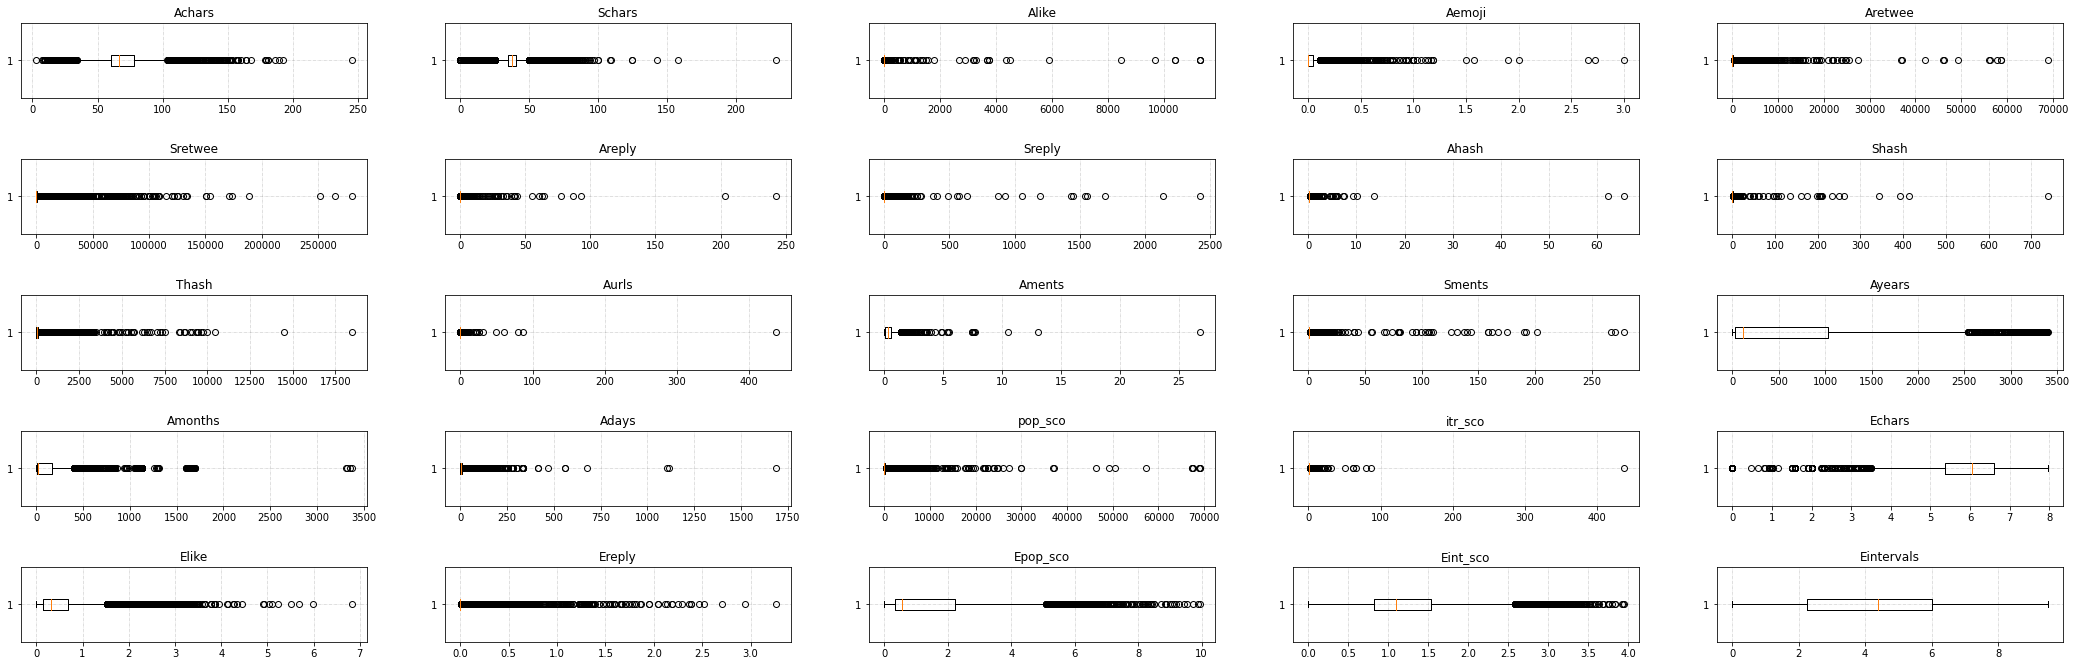

In [ ]:
nrow = math.ceil(len(indct_attr.columns)/5)

f, axs = plt.subplots(nrows = nrow, ncols = 5, figsize=(30,nrow*2))
f.tight_layout(pad=4)

for i in range(len(indct_attr.columns)):
    axs[int(i/5)][i%5].boxplot(indct_attr[indct_attr.columns[i]],vert=False)
    axs[int(i/5)][i%5].set_title(indct_attr.columns[i])
    axs[int(i/5)][i%5].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
plt.show()


In [ ]:
outliers = pd.DataFrame(columns=indct_attr.columns,index=indct_attr.index)    
outliers.drop(outliers.index, inplace=True)

thresholds = {
  "Achars": 200,     "Schars": 110,    "Alike": 2000,            "Aemoji":1.5,             "Aretwee": 30000,
  "Sretwee": 150000, "Areply": 100,    "Sreply": 1500,           "Ahash":20,               "Shash":200,
  "Thash":7500,      "Aurls":100,      "Aments":10,              "Sments":150,             "Ayears": float('inf'),
  "Amonths": 2000,   "Adays": 350,     "pop_sco": 2000,          "itr_sco": 40,            "Echars": float('inf'), 
  "Elike": 5,        "Ereply": 2.5,    "Epop_sco": float('inf'), "Eint_sco": float('inf'), "Eintervals": float('inf')}
  
for idx,attribute in enumerate(indct_attr.columns):

    tmp = indct_attr[attribute]
    outliers = outliers.append(indct_attr[tmp > thresholds[attribute]])

outliers.drop_duplicates(inplace=True)

print("Remain ", round(1-len(outliers)/len(indct_attr),2)," %")

Remain  0.96  %


In [ ]:
outliers

,Achars,Schars,Alike,Aemoji,Aretwee,Sretwee,Areply,Sreply,Ahash,Shash,...,Amonths,Adays,pop_sco,itr_sco,Echars,Elike,Ereply,Epop_sco,Eint_sco,Eintervals
user_id,,,,,,,,,,,,,,,,,,,,,
1386519432,245.0,229.102597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
164239619,181.166667,158.394119,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.000000,2.000000,0.000000,0.250000,3.584963,-0.000000,-0.000000,-0.000000,0.811278,3.027169
253153974,145.625,125.085042,1.750000,0.125000,87.125000,136.301596,15.250000,36.468186,0.875000,0.353553,...,4.000000,2.666667,104.125000,1.500000,2.750000,1.548795,1.548795,2.405639,1.000000,1.664498
1218517542,119.0,142.835570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
1373615816,109.0,125.078642,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.333333,0.000000,0.000000,2.000000,-0.000000,-0.000000,-0.000000,-0.000000,1.584963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070386470,93.044667,34.409762,15.972957,0.081434,10.999088,11.058218,0.000000,0.000000,0.092981,0.335149,...,365.666667,30.757009,26.972045,0.240352,6.734781,5.090423,-0.000000,7.104503,0.658775,4.506710
86432824,47.334018,32.352267,29.726215,0.012320,43.703628,824.297096,0.000000,0.000000,0.102669,0.422484,...,121.750000,6.522321,73.429843,1.267625,6.516299,5.514932,-0.000000,6.784680,1.986798,6.382600
611525563,87.560206,27.890456,15.346982,0.000000,13.221717,11.142215,0.000000,0.000000,0.001517,0.052233,...,299.727273,11.101010,28.568699,0.003336,6.544031,5.221827,-0.000000,7.150809,0.015928,2.040770


In [ ]:
indicators.drop(outliers.index, inplace=True)

## Correlation matrix

After removed the outlier, we want to find which are the attributes that are correlated to each other to remove them and obtain a not-correlated dataset to use in cluster analysis

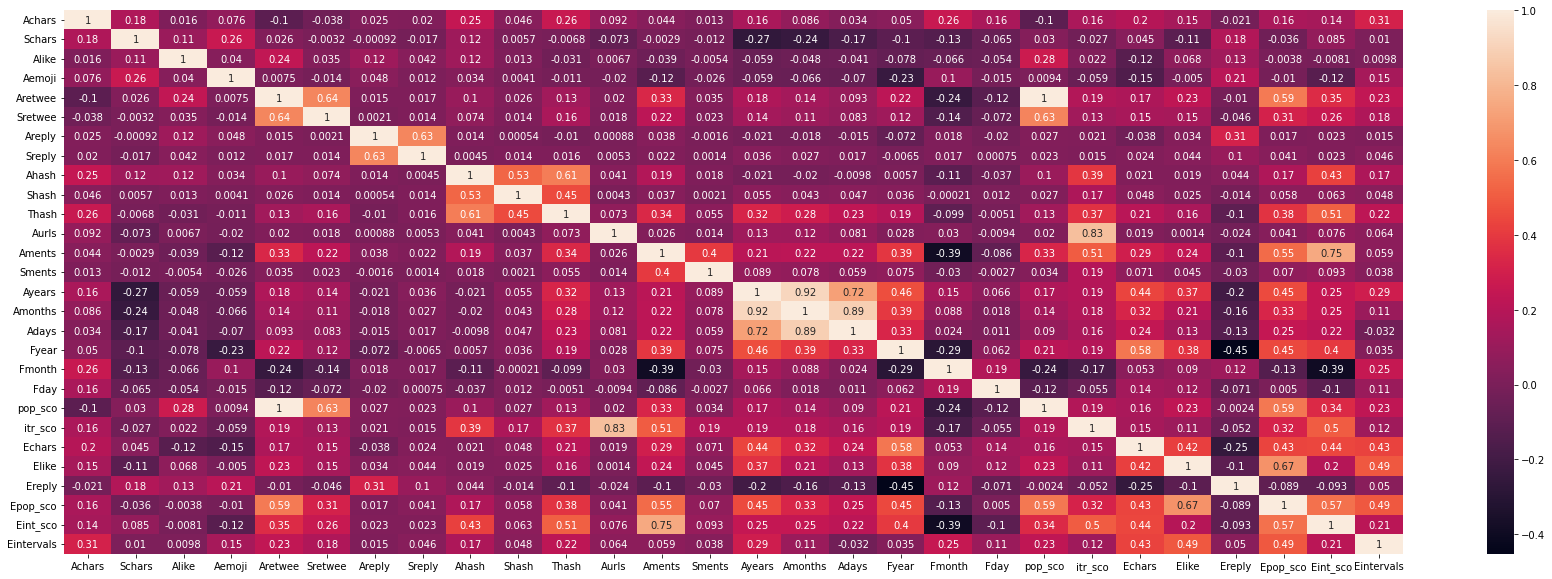

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
sn.heatmap(indicators.corr(), annot=True)
plt.show()

In [ ]:
indicators.Achars = indicators.Achars.astype("float")
# indicators.RtextLike = indicators.RtextLike.astype("float")

In [ ]:
corr_threshold = 0.80
print("Att. A\t\tAtt. B\t\tCorr(A,B)")
for i in range(0, len(indicators.columns)):
    for j in range(i+1, len(indicators.columns)):
        corr = indicators[indicators.columns[i]].corr(indicators[indicators.columns[j]])
        if  corr > corr_threshold:
            print(indicators.columns[i] + "\t\t" + indicators.columns[j] + "\t\t" + '{:.4f}'.format(corr))

Att. A		Att. B		Corr(A,B)
Aretwee		pop_sco		0.9991
Aurls		itr_sco		0.8325
Ayears		Amonths		0.9166
Amonths		Adays		0.8901


In [ ]:
indicators.drop(["Aretwee","Aurls","Amonths"],axis=1, inplace=True)

## Charts

In [ ]:
indct_attr = indicators.iloc[:,[*range(0,14)]+[*range(17,25)]]

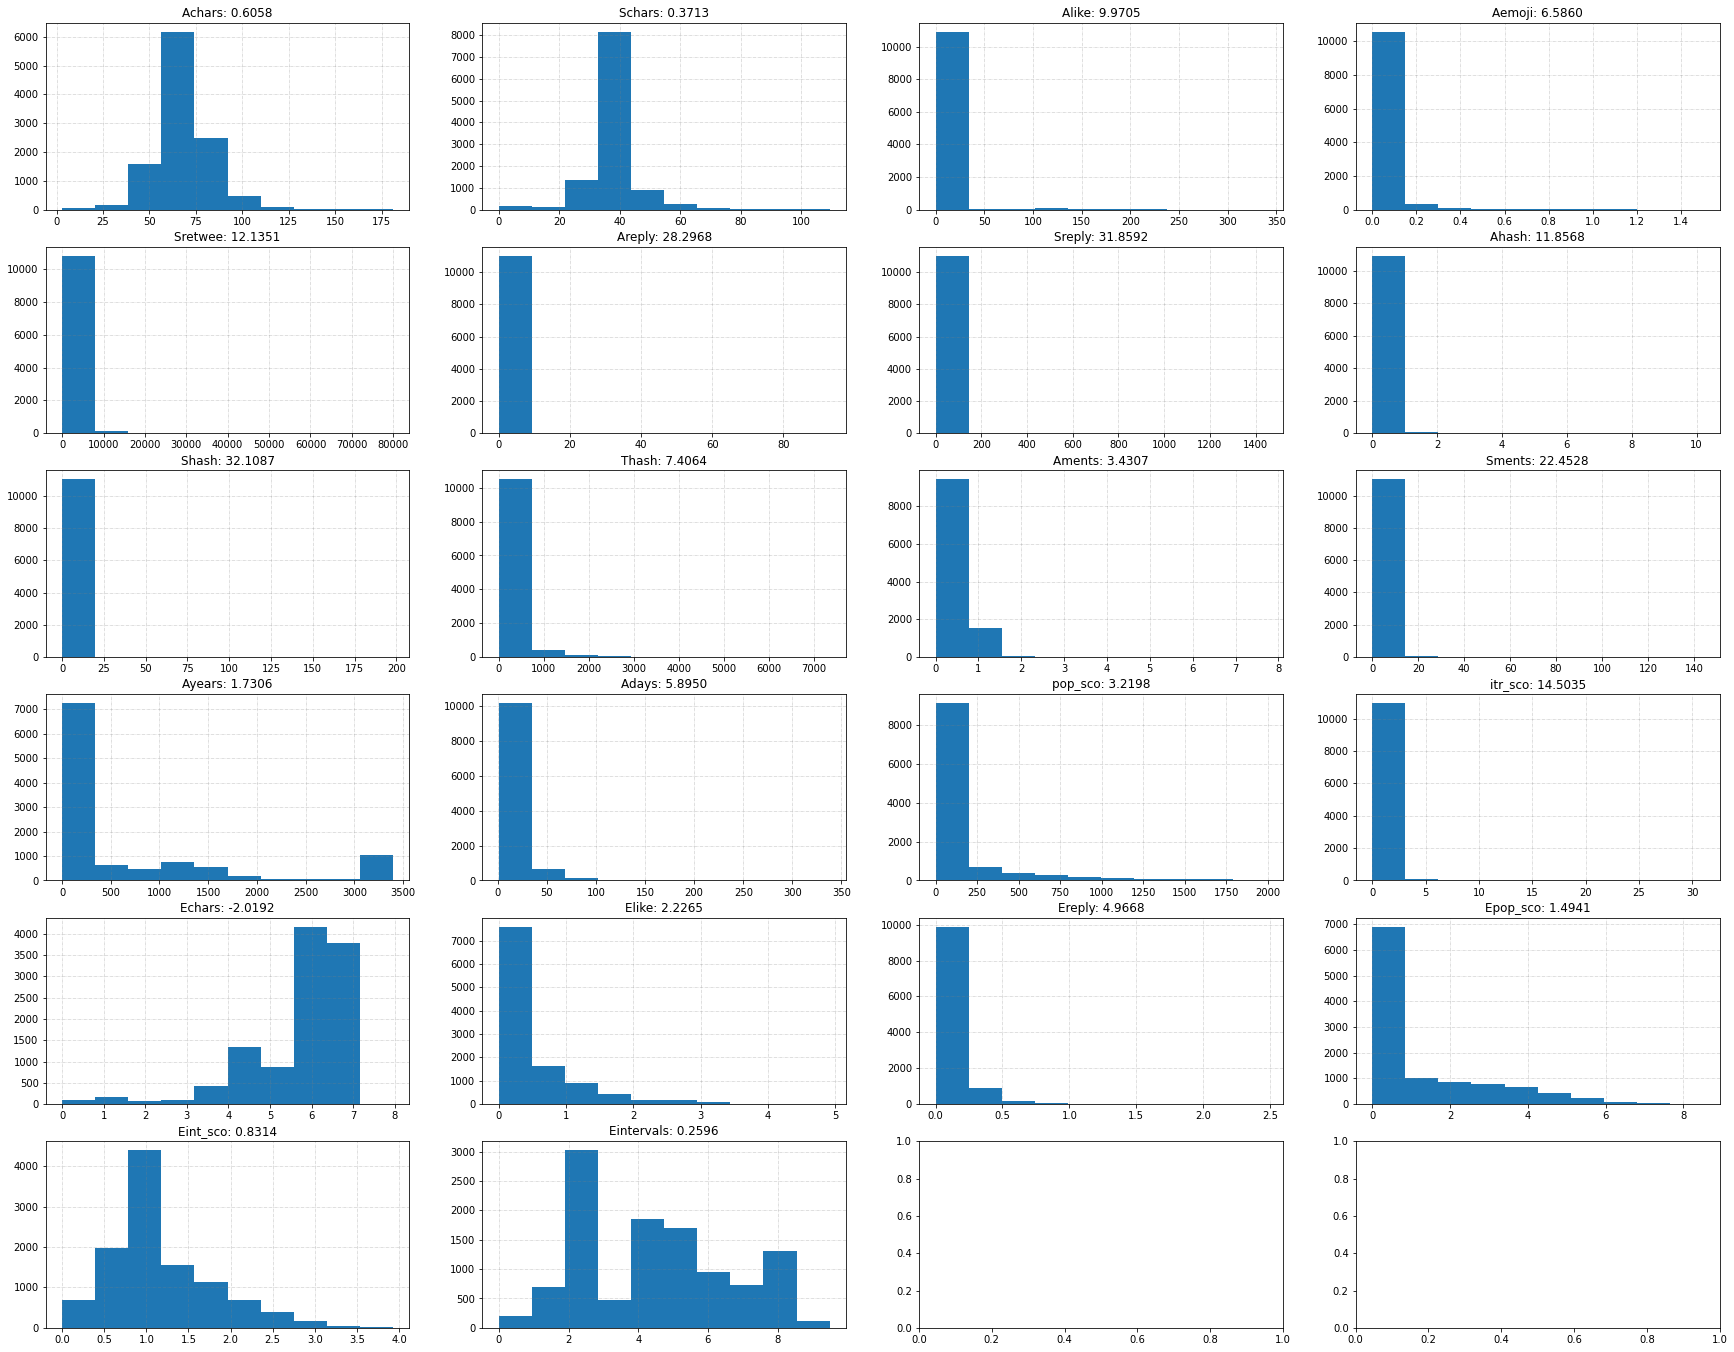

In [ ]:
nrow = math.ceil(len(indct_attr.columns)/4)

f, axs = plt.subplots(nrows = nrow, ncols = 4, figsize=(30,nrow*4))
for idx,attrib in enumerate(indct_attr.columns):

    axs[int(idx/4)][idx%4].hist(indct_attr[attrib])
    axs[int(idx/4)][idx%4].set_title(attrib + ": " + '{:.4f}'.format(indct_attr[attrib].skew()))
    axs[int(idx/4)][idx%4].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)
plt.show()

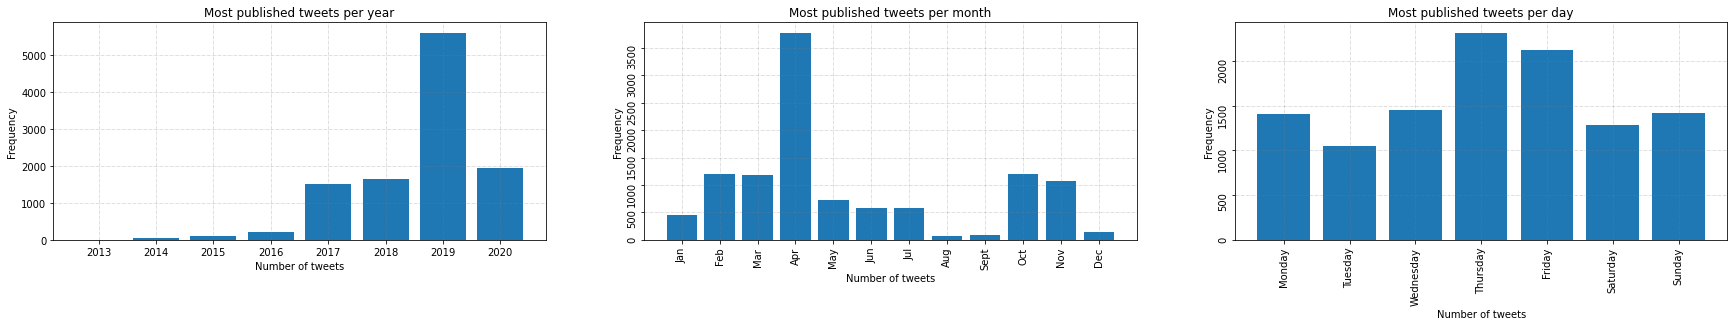

In [ ]:
f, axs = plt.subplots(ncols = 3, figsize=(30,4))

axs[0].bar(sorted(indicators.Fyear.unique()),indicators.Fyear.value_counts().sort_index())
axs[0].set_title("Most published tweets per year")
axs[0].set_xlabel("Number of tweets")
axs[0].set_ylabel("Frequency")
axs[0].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)

axs[1].bar(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"],indicators.Fmonth.value_counts().sort_index())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Most published tweets per month")
axs[1].set_xlabel("Number of tweets")
axs[1].set_ylabel("Frequency")
axs[1].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)

axs[2].bar(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],indicators.Fday.value_counts().sort_index())
axs[2].tick_params(labelrotation=90)
axs[2].set_title("Most published tweets per day")
axs[2].set_xlabel("Number of tweets")
axs[2].set_ylabel("Frequency")
axs[2].grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.5)

plt.show()

In [ ]:
users[users.real== True].describe()

,user_id,statuses_count
count,6.116000e+03,6116.000000
mean,1.355470e+09,1185.102845
std,8.765185e+08,5373.550630
min,1.093557e+07,0.000000
25%,5.389019e+08,32.000000
50%,1.174713e+09,53.000000
75%,2.357982e+09,78.000000
max,2.525273e+09,214410.000000


In [ ]:
users[users.real== False].describe()

,user_id,statuses_count
count,5.392000e+03,5392.000000
mean,1.182694e+09,10784.382604
std,9.901204e+08,25888.541443
min,6.780330e+05,0.000000
25%,2.707423e+08,59.000000
50%,8.584183e+08,1308.500000
75%,2.353852e+09,10155.750000
max,3.164942e+09,399555.000000


In [ ]:
users.describe()

,user_id,statuses_count
count,1.150800e+04,11508.000000
mean,1.274517e+09,5682.784150
std,9.354135e+08,18769.303622
min,6.780330e+05,0.000000
25%,4.663594e+08,41.000000
50%,1.128643e+09,68.000000
75%,2.357148e+09,2525.750000
max,3.164942e+09,399555.000000


In [ ]:
users.set_index("user_id", inplace=True)
users = pd.concat([users,indicators], axis=1, join="inner")

In [ ]:
users

,name,lang,real,created_at,statuses_count,Achars,Schars,Alike,Aemoji,Sretwee,...,Fmonth,Fday,pop_sco,itr_sco,Echars,Elike,Ereply,Epop_sco,Eint_sco,Eintervals
user_id,,,,,,,,,,,,,,,,,,,,,
2353593986,Lamonica Raborn,en,True,2019-02-22 18:00:42,76.0,63.423729,36.520550,0.042373,0.000000,0.158080,...,4,3,0.067797,0.406780,6.147101,0.253068,-0.0,0.359847,1.151594,2.500301
2358850842,Lourie Botton,en,False,2019-02-26 03:02:32,54.0,68.000000,40.894249,0.056075,0.000000,0.165856,...,4,6,0.084112,0.439252,5.974746,0.311662,-0.0,0.416505,1.050735,2.332769
137959629,Dadan Syarifudin,en,True,2015-04-30 07:09:56,3.0,17.333333,6.658328,0.000000,0.000000,0.000000,...,6,4,0.000000,0.000000,1.584963,-0.000000,-0.0,-0.000000,-0.000000,1.000000
466124818,Carletto Focia,it,True,2017-01-18 02:49:18,50.0,89.353834,34.269215,0.185304,0.046326,13.970827,...,11,4,1.130192,0.112620,6.756737,0.722547,-0.0,0.967681,0.476278,8.016912
2571493866,MBK Ebook,en,False,2019-06-18 19:30:21,7085.0,71.771845,33.398802,0.058859,0.003337,0.143672,...,4,4,0.076153,0.689320,6.839448,0.327648,-0.0,0.398517,1.437846,6.270884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901595415,Prity Baleja,en,False,2018-09-26 19:48:46,359.0,84.367568,39.378368,0.224324,0.013514,171.879072,...,4,3,18.181081,2.059459,6.546464,0.827101,-0.0,2.120637,2.861209,7.580095
1378532629,Clau Sato,en,False,2018-04-27 03:01:58,3024.0,58.939490,39.172949,0.208068,0.007962,4587.136037,...,6,5,414.346603,0.796709,6.843399,0.798109,-0.0,1.939582,1.720770,6.387872
126984069,ALMA LETICIA NUÑO,es,False,2015-03-29 17:01:24,6.0,67.666667,29.527388,0.000000,0.000000,0.000000,...,8,5,0.000000,1.000000,2.584963,-0.000000,-0.0,-0.000000,1.459148,2.321928


In [ ]:
users.to_csv("/content/drive/MyDrive/DataMining/users2clust.csv", index=True)